# Download Data from Google Cloud Storage

[GCP Dataset](https://console.cloud.google.com/storage/browser/waymo_open_dataset_v_2_0_1/training/camera_image;tab=objects?pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))&invt=AbuKSg&prefix=&forceOnObjectsSortingFiltering=false)

Download from the `camera_image` (raw images) and `camera_box` (bounding box labels) folders

In [ ]:
#@title Initial setup
from typing import Optional
import warnings
# Disable annoying warnings from PyArrow using under the hood.
warnings.simplefilter(action='ignore', category=FutureWarning)


import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import albumentations as A
import numpy as np
import os
import pandas as pd
from PIL import Image
import dask.dataframe as dd
from waymo_open_dataset import v2

In [ ]:
def read_parquet(dataset_dir: str, tag: str, context_name: str,) -> dd.DataFrame:
    """Creates a Dask DataFrame for the component specified by its tag."""
    paths = tf.io.gfile.glob(f'{dataset_dir}/{tag}/{context_name}.parquet')
    return dd.read_parquet(paths)

def read_image_and_box_files(dataset_dir: str, context_name: str):
    cam_image_df = read_parquet(dataset_dir, 'camera_image', context_name)
    cam_box_df = read_parquet(dataset_dir, 'camera_box', context_name)
    image_w_box_df = v2.merge(cam_image_df, cam_box_df, right_group=True)
    return image_w_box_df

def get_single_image_and_boxes(data_row: dict):
    cam_image = v2.CameraImageComponent.from_dict(data_row)
    cam_box = v2.CameraBoxComponent.from_dict(data_row)
    return cam_image, cam_box

In [ ]:
dataset_dir = "./data/raw_data"
context_name = "10023947602400723454_1120_000_1140_000"

In [ ]:
image_w_box_df = read_image_and_box_files(dataset_dir, context_name)

In [ ]:
def show_camera_image(camera_image, camera_labels, layout, cmap=None):
  """Show a camera image and the given camera labels."""

  ax = plt.subplot(*layout)

  # Iterate over the individual labels.
  for i, t in enumerate(camera_labels.type):
    # Draw the object bounding box.
    ax.add_patch(patches.Rectangle(
      xy=(camera_labels.box.center.x[i] - 0.5 * camera_labels.box.size.x[i],
          camera_labels.box.center.y[i] - 0.5 * camera_labels.box.size.y[i]),
      width=camera_labels.box.size.x[i],
      height=camera_labels.box.size.y[i],
      linewidth=1,
      edgecolor='red' if cmap is None else cmap.colors[(t - 1) % cmap.N],
      facecolor='none'))

  # Show the camera image.
  plt.imshow(tf.image.decode_jpeg(camera_image.image))
  plt.grid(False)
  plt.axis('off')

2025-04-07 21:37:57.028321: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-07 21:37:57.031946: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


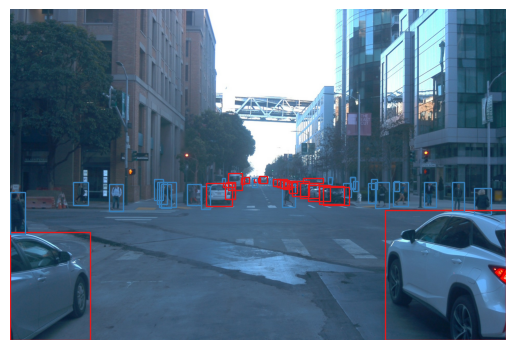

Context Name: 10023947602400723454_1120_000_1140_000
Frame Timestamp: 1552440195362591
Camera Name: 1


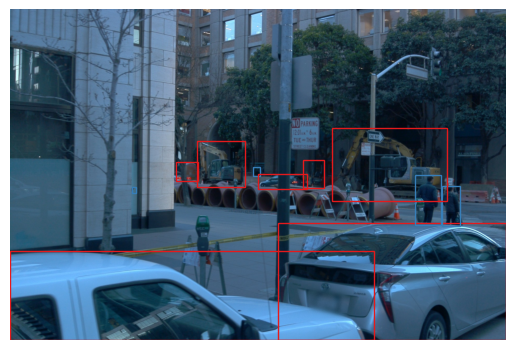

Context Name: 10023947602400723454_1120_000_1140_000
Frame Timestamp: 1552440195362591
Camera Name: 2


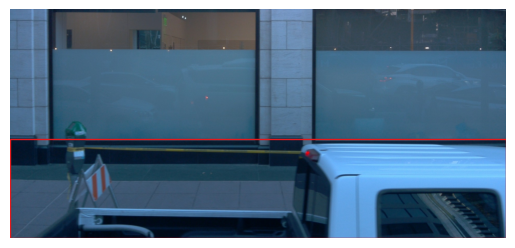

Context Name: 10023947602400723454_1120_000_1140_000
Frame Timestamp: 1552440195362591
Camera Name: 4


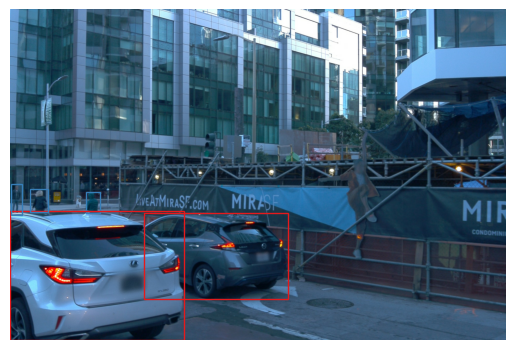

Context Name: 10023947602400723454_1120_000_1140_000
Frame Timestamp: 1552440195362591
Camera Name: 3


<Figure size 640x480 with 0 Axes>

In [ ]:
for i, (_, r) in enumerate(image_w_box_df.iterrows()):
  if i > 3: break
  # Create component dataclasses for the raw data
  cam_image = v2.CameraImageComponent.from_dict(r)
  cam_box = v2.CameraBoxComponent.from_dict(r)
  show_camera_image(cam_image, cam_box, (1, 1, 1), plt.get_cmap("Set1"))
  plt.show()
  plt.clf()
  print("Context Name:", cam_image.key.segment_context_name)
  print("Frame Timestamp:", cam_image.key.frame_timestamp_micros)
  print("Camera Name:", cam_image.key.camera_name)

In [ ]:
def create_bounding_box_list(cam_box: v2.perception.box.CameraBoxComponent, image_size: tuple[int, int]):
    bboxes = []
    for x, y, w, h, l in zip(cam_box.box.center.x, cam_box.box.center.y, cam_box.box.size.x, cam_box.box.size.y, cam_box.type):
        x = x / image_size[0]
        y = y / image_size[1]
        w = w /image_size[0]
        h = h / image_size[1]
        bboxes.append([x, y, w, h, str(l)])
    return bboxes

In [ ]:
def show_transformed_image(image, boxes, layout=(1, 1, 1)):
    ax = plt.subplot(*layout)

    # Iterate over the individual labels.
    width = image.shape[1]
    height = image.shape[0]
    for i, box in enumerate(boxes):
        # Draw the object bounding box.
        ax.add_patch(patches.Rectangle(
        xy=((box[0] - 0.5 * box[2]) * width,
            (box[1] - 0.5 * box[3]) * height),
        width=box[2] * width,
        height=box[3] * height,
        linewidth=1,
        edgecolor='red',
        facecolor='none'))

    # Show the camera image.
    plt.imshow(image)
    plt.grid(False)
    plt.axis('off')

In [ ]:
transform = A.Compose([
    A.Resize(640, 640),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
], bbox_params=A.BboxParams(format='yolo'))

In [ ]:
image = tf.image.decode_jpeg(cam_image.image).numpy()
bboxes = create_bounding_box_list(cam_box, [image.shape[1], image.shape[0]])
transformed = transform(image=image, bboxes=bboxes)

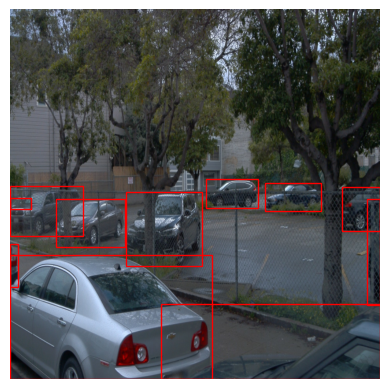

In [ ]:
show_transformed_image(transformed["image"], transformed["bboxes"])

In [ ]:
def get_possible_from_scene(cam_image, cam_box, min_pedestrian_pixels=12288):
    image = tf.image.decode_jpeg(cam_image.image).numpy()
    image_width = image.shape[1]
    image_height = image.shape[0]

    bboxes = []
    for x, y, w, h, l in zip(cam_box.box.center.x, cam_box.box.center.y, cam_box.box.size.x, cam_box.box.size.y, cam_box.type):
        if l != 2: continue

        num_label_pixels = w * h
        if num_label_pixels > min_pedestrian_pixels:
            x = x / image_width
            y = y / image_height
            w = w / image_width
            h = h / image_height
            bboxes.append([x, y, w, h, "pedestrian"])

    if len(bboxes) == 0:
        return None
    return image, bboxes

In [ ]:
context_names = [n[:-8] for n in os.listdir(f"{dataset_dir}/camera_image")]
selected_data_dir = "./data/selected_data"
selected_images_dir = selected_data_dir + "/images"
selected_bboxes_dir = selected_data_dir + "/bboxes"
os.mkdir(selected_data_dir)
os.mkdir(selected_images_dir)
os.mkdir(selected_bboxes_dir)

In [ ]:
np.random.seed(0)

image_num = 0
for context_name in context_names:
    image_w_box_df = read_image_and_box_files(dataset_dir, context_name)

    rand_img_indexes = np.arange(image_w_box_df.shape[0].compute())
    np.random.shuffle(rand_img_indexes)
    rand_img_indexes = rand_img_indexes[:50]

    for i, (_, r) in enumerate(image_w_box_df.iterrows()):
        if i not in rand_img_indexes:
            continue

        # Create component dataclasses for the raw data
        cam_image = v2.CameraImageComponent.from_dict(r)
        cam_box = v2.CameraBoxComponent.from_dict(r)
        output = get_possible_from_scene(cam_image, cam_box)
        if output is None:
            continue

        im = Image.fromarray(output[0])
        im.save(f"{selected_images_dir}/{image_num}.png")
        bb = pd.DataFrame(output[1], columns=["center_x", "center_y", "width", "height", "label"])
        bb.to_csv(f"{selected_bboxes_dir}/{image_num}.csv")
        image_num += 1

In [ ]:
def get_iou(bb1, bb2, in_yolo_format=True):
    if in_yolo_format:
        bb1_right = bb1[0] + bb1[2] / 2
        bb1_left = bb1[0] - bb1[2] / 2
        bb1_bottom = bb1[1] + bb1[3] / 2
        bb1_top = bb1[1] - bb1[3] / 2

        bb2_right = bb2[0] + bb2[2] / 2
        bb2_left = bb2[0] - bb2[2] / 2
        bb2_bottom = bb2[1] + bb2[3] / 2
        bb2_top = bb2[1] - bb2[3] / 2
    else:
        bb1_left, bb1_right, bb1_top, bb1_bottom = bb1
        bb2_left, bb2_right, bb2_top, bb2_bottom = bb2

    intersection_width = min(bb1_right, bb2_right) - max(bb1_left, bb2_left)
    intersection_height = min(bb1_bottom, bb2_bottom) - max(bb1_top, bb2_top)

    if intersection_width <= 0 or intersection_height <= 0:
        return 0

    intersection_area = intersection_width * intersection_height

    bb1_area = (bb1_right - bb1_left) * (bb1_bottom - bb1_top)
    bb2_area = (bb2_right - bb2_left) * (bb2_bottom - bb2_top)

    union_area = bb1_area + bb2_area - intersection_area
    iou = intersection_area / union_area
    return iou

In [ ]:
get_iou([0, 0, 1, 1], [0, 0, 1, 1])

1.0

In [ ]:
training_transform = A.Compose([
    A.Resize(640, 640),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.25),
    A.RandomRotate90(p=0.25)
], bbox_params=A.BboxParams(format='yolo'))

testing_transform = A.Compose([
    A.Resize(640, 640),
], bbox_params=A.BboxParams(format='yolo'))

In [ ]:
np.random.seed(42)

num_images = len(os.listdir(selected_images_dir))
dataset_sizes = [0.5, .25, .25]
shuffled_indexes = np.arange(num_images)
np.random.shuffle(shuffled_indexes)

train_indexes = shuffled_indexes[:int(dataset_sizes[0] * num_images)]
val_indexes = shuffled_indexes[int(dataset_sizes[0] * num_images):int((dataset_sizes[0] + dataset_sizes[1]) * num_images)]
test_indexes = shuffled_indexes[int((dataset_sizes[0] + dataset_sizes[1]) * num_images):]

In [ ]:
def transform_and_save_data(selected_data_dir, transformed_data_dir, file_names, transform):
    transformed_images_dir = transformed_data_dir + "/images"
    transformed_bboxes_dir = transformed_data_dir + "/bboxes"
    os.mkdir(transformed_data_dir)
    os.mkdir(transformed_images_dir)
    os.mkdir(transformed_bboxes_dir)

    for n in file_names:
        orig_image = Image.open(f"{selected_data_dir}/images/{n}.png")
        orig_bbox = pd.read_csv(f"{selected_data_dir}/bboxes/{n}.csv", index_col=0)

        image = np.array(orig_image)
        bboxes = orig_bbox.values.tolist()

        transformed = transform(image=image, bboxes=bboxes)

        im = Image.fromarray(transformed["image"])
        im.save(f"{transformed_images_dir}/{n}.png")
        bb = pd.DataFrame(transformed["bboxes"], columns=["center_x", "center_y", "width", "height", "label"])
        bb.to_csv(f"{transformed_bboxes_dir}/{n}.csv")

In [ ]:
np.random.seed(42)

transformed_data_dir = "./data/transformed_data"
os.mkdir(transformed_data_dir)

transform_and_save_data(
    selected_data_dir,
    "./data/transformed_data/train",
    train_indexes,
    training_transform
)

transform_and_save_data(
    selected_data_dir,
    "./data/transformed_data/val",
    val_indexes,
    testing_transform
)

transform_and_save_data(
    selected_data_dir,
    "./data/transformed_data/test",
    test_indexes,
    testing_transform
)

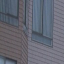

In [ ]:
Image.fromarray(image).crop((0, 0, 64, 64))

In [ ]:
def is_pedestrian_in_sub_image(sub_image_bounds, image_size, labels, min_percentage=0.25):
    left = sub_image_bounds[0]
    right = sub_image_bounds[1]
    top = sub_image_bounds[2]
    bottom = sub_image_bounds[3]

    image_width = image_size[0]
    image_height = image_size[1]
    for l in labels:
        l_left = (l[0] - l[2] / 2) * image_width
        l_right = (l[0] + l[2] / 2) * image_width
        l_top = (l[1] - l[3] / 2) * image_height
        l_bottom = (l[1] + l[3] / 2) * image_height

        cl_left = max(left, l_left)
        cl_right = min(right, l_right)
        cl_top = max(top, l_top)
        cl_bottom = min(bottom, l_bottom)

        if cl_right < cl_left or cl_bottom < cl_top:
            iou = 0
        else:
            iou = get_iou((left, right, top, bottom), (cl_left, cl_right, cl_top, cl_bottom), in_yolo_format=False)

        if iou > min_percentage:
            return True

    return False


def create_sub_images(image, labels, sub_image_size=64):
    im = Image.fromarray(image)

    sub_images = []
    sub_image_contains_pedestrian = []
    for y in range(image.shape[0] // sub_image_size):
        for x in range(image.shape[1] // sub_image_size):
            left = x * sub_image_size
            right = left + sub_image_size
            top = y * sub_image_size
            bottom = top + sub_image_size
            sub_image = im.crop((left, top, right, bottom))
            sub_images.append(np.array(sub_image))
            sub_image_contains_pedestrian.append(
                is_pedestrian_in_sub_image((left, right, top, bottom), (image.shape[1], image.shape[0]), labels)
            )
    return sub_images, (image.shape[0] // sub_image_size, image.shape[1] // sub_image_size), sub_image_contains_pedestrian

In [ ]:
orig_image = Image.open(f"./data/transformed_data/train/images/{310}.png")
orig_bbox = pd.read_csv(f"./data/transformed_data/train/bboxes/{310}.csv", index_col=0)

image = np.array(orig_image)
bboxes = orig_bbox.values.tolist()

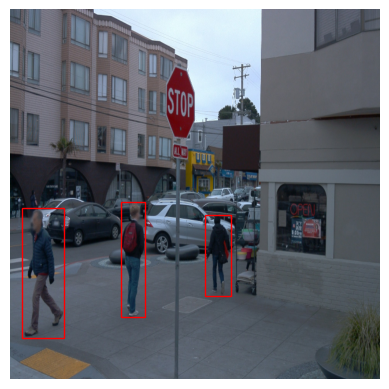

In [ ]:
show_transformed_image(image, bboxes)

In [ ]:
sub_images, grid_shape, pedestrian_in_sub_image = create_sub_images(
    image,
    bboxes
)

In [ ]:
def reconstruct_sub_images(sub_images, num_sub_images):
    rows = []
    for y in range(num_sub_images[1]):
        row = []
        for x in range(num_sub_images[0]):
            row.append(sub_images[x + y * num_sub_images[1]])
        rows.append(np.concatenate(row, axis=1))
    return np.concatenate(rows, axis=0)

In [ ]:
def plot_sub_image_predictions(sub_images, num_sub_images, sub_images_sizes, sub_image_preds, layout=(1, 1, 1)):
    image = reconstruct_sub_images(sub_images, num_sub_images)
    ax = plt.subplot(*layout)

    for y in range(num_sub_images[1]):
        for x in range(num_sub_images[0]):
            i = x + y * num_sub_images[0]
            if not sub_image_preds[i]:
                continue

            ax.add_patch(patches.Rectangle(
                xy=(x * sub_images_sizes[0],
                    y * sub_images_sizes[1]),
                width=sub_images_sizes[0],
                height=sub_images_sizes[1],
                linewidth=1,
                edgecolor='red',
                facecolor='none')
            )
    plt.imshow(image)
    plt.grid(False)
    plt.axis('off')

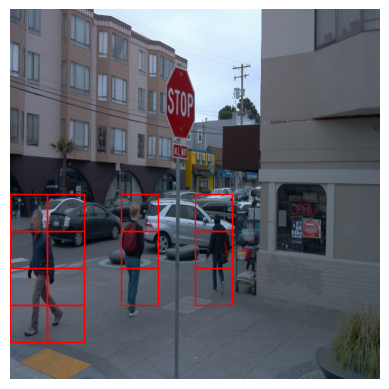

In [ ]:
plot_sub_image_predictions(sub_images, grid_shape, (64, 64), pedestrian_in_sub_image)